In [1]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
import datetime
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

### Cargo los datos y sets

In [2]:
training_labels = pd.read_csv("labels_training_set.csv", low_memory=False)
labels_predict = pd.read_csv("trocafone_kaggle_test.csv", low_memory=False)
events_data = pd.read_csv("features.csv", low_memory = False)

### Comenzamos con el set de entrenamiento

In [13]:
set_entrenamiento = pd.merge(events_data, training_labels, on ='person', how = 'inner')

In [14]:
set_entrenamiento = set_entrenamiento.drop(columns = ['person'])
set_entrenamiento.head()

,ad campaign hit,brand listing,checkout,conversion,generic listing,lead,search engine hit,searched products,staticpage,viewed product,visited site,promedio dias,condicion,promedio hora,label
0,0,0,3,0,1,0,0,0,0,0,2,17.000000,3,14.333333,0
1,1,0,1,0,1,0,1,9,0,3,1,29.000000,4,0.000000,0
2,5,0,1,0,4,0,0,4,0,4,1,31.000000,5,17.000000,0
3,29,165,15,2,28,0,13,11,0,189,19,17.282378,206,14.940552,0
4,0,1,2,1,1,0,0,0,0,2,0,22.000000,5,14.000000,0


In [15]:
X = set_entrenamiento.drop(columns = ['label'])
y = set_entrenamiento["label"]

In [16]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=123)

In [17]:
data_dmatrix = xgb.DMatrix(data=X,label=y)

In [18]:
xg_reg = xgb.XGBRegressor(objective ='reg:linear', 
                colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 5, n_estimators = 10)

In [19]:
xg_reg.fit(x_train,y_train)

XGBRegressor(alpha=5, base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.3, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=10,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [20]:
preds = xg_reg.predict(x_test)
preds = preds.tolist()
df = pd.DataFrame(preds)
df = df[0].map(lambda x: 1 if x > 0.5 else 0);

0    0
1    0
2    0
3    0
4    0
Name: 0, dtype: int64

In [21]:
df.value_counts()

0    7766
Name: 0, dtype: int64

In [22]:
accuracy_score(df,y_test)

0.9475920679886686

### Comenzamos con el set de test

In [23]:
set_test = pd.merge(events_data,labels_predict,on = "person", how = "right")
set_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19415 entries, 0 to 19414
Data columns (total 15 columns):
person               19415 non-null object
ad campaign hit      19415 non-null int64
brand listing        19415 non-null int64
checkout             19415 non-null int64
conversion           19415 non-null int64
generic listing      19415 non-null int64
lead                 19415 non-null int64
search engine hit    19415 non-null int64
searched products    19415 non-null int64
staticpage           19415 non-null int64
viewed product       19415 non-null int64
visited site         19415 non-null int64
promedio dias        19415 non-null float64
condicion            19415 non-null int64
promedio hora        19415 non-null float64
dtypes: float64(2), int64(12), object(1)
memory usage: 2.4+ MB


In [24]:
personas = set_test["person"]
set_test = set_test.drop(columns=["person"])
set_test = set_test.fillna(0)

In [25]:
predicts_kaggel = xg_reg.predict(set_test)
set_test.tail()

,ad campaign hit,brand listing,checkout,conversion,generic listing,lead,search engine hit,searched products,staticpage,viewed product,visited site,promedio dias,condicion,promedio hora
19410,0,0,0,0,0,0,1,0,0,19,1,28.000000,19,14.476190
19411,1,0,1,0,0,0,0,0,0,1,1,22.000000,2,17.000000
19412,0,0,0,0,0,0,1,0,0,0,1,18.000000,0,19.000000
19413,7,1,1,1,12,0,12,8,3,42,10,11.010309,44,17.896907
19414,1,2,1,0,0,0,1,0,0,4,1,17.000000,5,22.000000


In [26]:
predicts_kaggel = predicts_kaggel.tolist()
df_kaggel = pd.DataFrame(predicts_kaggel)
df_kaggel.head()

,0
0,0.226918
1,0.235379
2,0.221460
3,0.218368
4,0.197246


In [27]:
df_kaggel[0].describe()

count    19415.000000
mean         0.207122
std          0.030853
min          0.179713
25%          0.187272
50%          0.194153
75%          0.218484
max          0.649984
Name: 0, dtype: float64

In [28]:
df_kaggel = df_kaggel[0].map(lambda x: 1 if x > 0.207122 else 0);
df_kaggel = df_kaggel.to_frame()
df_kaggel["person"] = personas
df_kaggel.rename(columns = {0: 'label'},inplace = True) 

In [29]:
df_kaggel = df_kaggel[['person','label']]

### Vemos resultados y pasamos a un csv

In [30]:
df_kaggel['label'].value_counts()

0    13016
1     6399
Name: label, dtype: int64

In [31]:
df_kaggel.to_csv('Resultados.csv',index=False)

### Vemos la importancia de cada feature

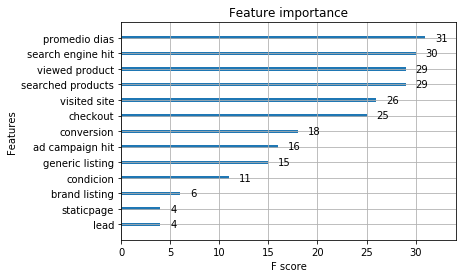

In [35]:
import matplotlib.pyplot as plt
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [30, 30]
plt.show()

In [34]:
#Pruebas anteriores
#marcas + condicion + color + storage + promedio dias+ promedio horas = malo (color aportaba muy poco) #0.74"
#marcas + condicion + storage + promedio dias+ promedio horas = safa (0.76110)
#condicion + storage + promedio dias+ promedio horas =  (0.76409)
#condicion + promedio dias+ promedio horas =  (0.76688)
#
#
#